In [34]:
# was ist mit GPUs, beschleunigung?
# random vektoren normalisieren.
# wo liegen normale gewichte? durchstoßen wir hier grenzen?
# per layer steps
# imageNET tiny, CIFAR, fashin-mnist
# matrizen loggen
# tensorflow timedistributed: wenn optimieren wichtig ist.
# wird das schon durch mathematik beschrieben?

In [1]:
#%matplotlib inline
%matplotlib widget
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

plt.rcParams['figure.dpi'] = 200


import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [130]:
ds = tfds.load('mnist', split='train', shuffle_files=True)

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

2021-11-03 16:13:57.399105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 16:13:57.449469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 16:13:57.449909: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 16:13:57.451846: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
#ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [29]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])
metrics=[
    (tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 'SparseCategoricalCrossentropy'),
    (tf.keras.metrics.SparseCategoricalAccuracy(), 'SparseCategoricalAccuracy')]
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[e[0] for e in metrics],
)

In [5]:
model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

2021-11-03 16:14:05.021812: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/6
469/469 [==============================] - 3s 4ms/step - loss: 0.3544 - sparse_categorical_crossentropy: 0.3543 - sparse_categorical_accuracy: 0.9017 - val_loss: 0.1918 - val_sparse_categorical_crossentropy: 0.1909 - val_sparse_categorical_accuracy: 0.9434
Epoch 2/6
469/469 [==============================] - 1s 2ms/step - loss: 0.1664 - sparse_categorical_crossentropy: 0.1663 - sparse_categorical_accuracy: 0.9520 - val_loss: 0.1349 - val_sparse_categorical_crossentropy: 0.1342 - val_sparse_categorical_accuracy: 0.9618
Epoch 3/6
469/469 [==============================] - 1s 2ms/step - loss: 0.1185 - sparse_categorical_crossentropy: 0.1185 - sparse_categorical_accuracy: 0.9663 - val_loss: 0.1105 - val_sparse_categorical_crossentropy: 0.1097 - val_sparse_categorical_accuracy: 0.9678
Epoch 4/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0912 - sparse_categorical_crossentropy: 0.0912 - sparse_categorical_accuracy: 0.9743 - val_loss: 0.0981 - val_sparse_categor

In [6]:
model.evaluate(ds_test)

79/79 [==============================] - 0s 1ms/step - loss: 0.0859 - sparse_categorical_crossentropy: 0.0851 - sparse_categorical_accuracy: 0.9744


[0.08588618040084839, 0.08514388650655746, 0.974399983882904]

In [7]:
def get_random_weights():
    random_weights = []
    for a in model.get_weights():
        random_weights.append(np.random.random(a.shape)*2-1)
    return random_weights

In [8]:
def flatten_weights(w):
    w1 = []
    for a in w:
        w1.append(np.ndarray.flatten(a))
    return np.concatenate(w1)

In [9]:
def expand_weights(v, shapes):
    w = []
    shape_sizes = [np.prod(s) for s in shapes]
    split_indicies = [shape_sizes[0]]
    for l in shape_sizes[1:]:
        split_indicies.append( split_indicies[-1] + l)
    w1 = np.split(v, split_indicies)[:-1]
    for s, w1_part in zip(shapes, w1):
        w.append(np.reshape(w1_part, s))
    return w

In [10]:
# random vectors. set them first, so we can explore freely afterwards
rx = 2*np.random.random(np.size(flatten_weights(model.get_weights())))-1
ry = 2*np.random.random(np.size(flatten_weights(model.get_weights())))-1

In [11]:
plt.close("all")

In [30]:
from functools import lru_cache

@lru_cache(maxsize=32)
def compute_losses(alpha, max_step):
    w_old = w = flatten_weights(model.get_weights())
    shapes = [s.shape for s in model.get_weights()]
    
    x_ticks = np.arange(-max_step, max_step)
    y_ticks = np.arange(-max_step, max_step)
    X, Y = np.meshgrid(x_ticks, y_ticks)
    
    def eval_step(x_tick, y_tick):
        w = w_old + x_tick*alpha * rx + y_tick*alpha * ry
        model.set_weights(expand_weights(w, shapes))
        metrics = model.evaluate(ds_test, verbose=0)
        pbar.update(1)
        return metrics
    evaluate = np.vectorize(eval_step, otypes=[object])
    with tqdm(total=np.size(X)) as pbar:
        Z = evaluate(X, Y)
    model.set_weights(expand_weights(w_old, shapes))
    
    return X, Y, Z

interactive(children=(FloatText(value=0.01, description='alpha'), IntText(value=2, description='max_step'), Dr…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
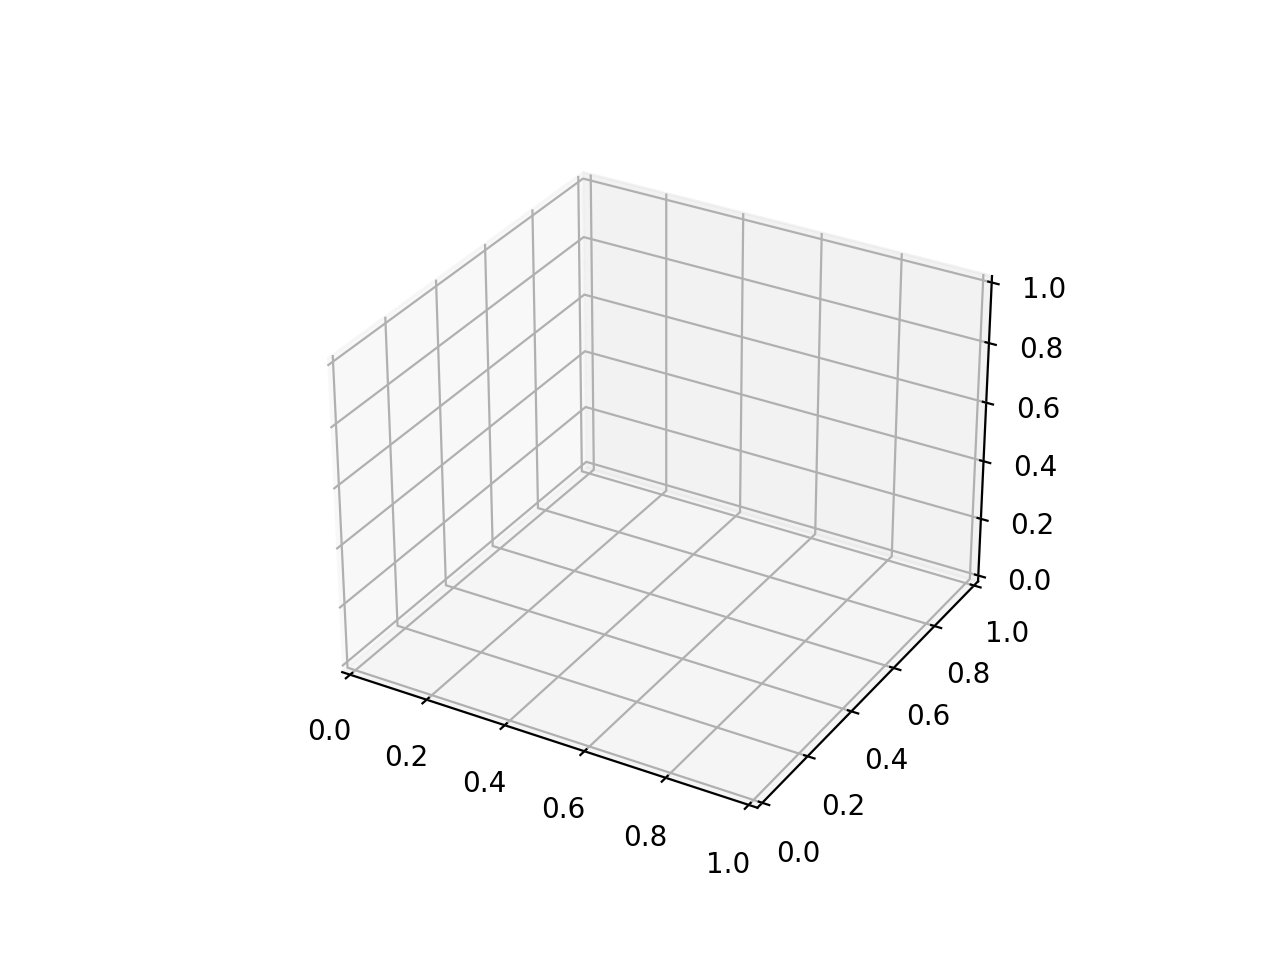

In [32]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

@interact_manual(alpha=widgets.FloatText(value=0.01), max_step=widgets.IntText(value=2), metric=[('loss', 0)]+[(e[1],i+1) for i, e in enumerate(metrics)])
def landscape(alpha=0.01, max_step=4, metric=0):
    
    ax.cla()
    #fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Make data.
    X, Y, metrics = compute_losses(alpha, max_step)
    
    def choose_metric(metric_list):
        return metric_list[metric]
    get_Z = np.vectorize(choose_metric, otypes=[float])
    Z = get_Z(metrics)
    
    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    #ax.zaxis.set_major_formatter('{x:.02f}')
    #fig.colorbar(surf, shrink=0.5, aspect=10)

In [84]:
@interact.options(manual=True)
def greeting(text="World"):
    print("Hello {}".format(text))

interactive(children=(Text(value='World', description='text'), Button(description='Run Interact', style=Button…

In [26]:
model.layers[1].get_weights()

[array([[ 0.02660616, -0.02686946, -0.06994642, ..., -0.04550598,
          0.05684874,  0.00180864],
        [ 0.05287934, -0.01794275,  0.02417303, ..., -0.00523295,
          0.05626892, -0.01375547],
        [-0.07490896,  0.05021379, -0.04490408, ..., -0.07918435,
         -0.06255273, -0.05429044],
        ...,
        [-0.03569955, -0.04900896, -0.05350608, ...,  0.05493832,
         -0.04809352,  0.07840014],
        [ 0.041572  ,  0.04771969, -0.02365122, ..., -0.00416334,
         -0.01546913, -0.04412607],
        [-0.0457702 , -0.01496361,  0.06792883, ...,  0.0689223 ,
         -0.07022363, -0.06747237]], dtype=float32),
 array([-3.41964047e-03,  4.59968857e-02,  6.22703433e-02,  1.18632400e-02,
         5.26186340e-02,  7.88371041e-02,  3.88644859e-02, -2.45209597e-02,
         8.26998875e-02,  1.50017902e-01,  3.08252387e-02, -1.79466903e-02,
        -9.47698876e-02, -1.82520170e-02, -3.03230397e-02,  4.29878011e-02,
         4.95704710e-02, -2.12050322e-02,  1.04761444e

In [27]:
np.dot(w, r2)

20.832265529750277

In [29]:
np.linalg.norm(w, ord=1)

7071.267

In [31]:
np.linalg.norm(r2, ord=1)

50879.29091725648

In [32]:
len(r1)

101770

In [18]:
r1 = get_random_weights()
r2 = get_random_weights()

In [51]:
w

[array([[-0.16888298, -0.87614519, -0.27124788, ...,  0.00569111,
          0.51903026, -0.96267681],
        [ 0.45234553,  0.79868451, -0.6507519 , ...,  0.90655505,
          0.49706323, -0.09863212],
        [ 0.99237552,  0.71506418, -0.11517515, ..., -0.05505343,
         -0.86718021,  0.20924428],
        ...,
        [ 0.29463461, -0.7255769 , -0.79833826, ...,  0.08187646,
          0.83062404,  0.87307578],
        [-0.16745735, -0.69216449,  0.01854408, ..., -0.64844049,
         -0.48972144,  0.30728545],
        [-0.1835336 ,  0.05506204,  0.70786078, ...,  0.76778835,
          0.67777739,  0.00186396]]),
 array([-1.74393452e-02,  6.77348943e-01,  1.72931103e-02,  1.79366138e-04,
        -5.14494830e-02, -5.99715980e-01,  6.47264210e-01,  7.45091563e-01,
         9.20268165e-01, -3.06257011e-01,  3.02711110e-02,  9.23116132e-01,
        -3.94458577e-01, -7.19334387e-01,  7.02106282e-01, -2.84123864e-01,
         6.40538133e-02,  6.79821486e-01, -1.93757603e-01,  2.7075973

In [43]:
r1

[array([[-0.16888298, -0.87614519, -0.27124788, ...,  0.00569111,
          0.51903026, -0.96267681],
        [ 0.45234553,  0.79868451, -0.6507519 , ...,  0.90655505,
          0.49706323, -0.09863212],
        [ 0.99237552,  0.71506418, -0.11517515, ..., -0.05505343,
         -0.86718021,  0.20924428],
        ...,
        [ 0.29463461, -0.7255769 , -0.79833826, ...,  0.08187646,
          0.83062404,  0.87307578],
        [-0.16745735, -0.69216449,  0.01854408, ..., -0.64844049,
         -0.48972144,  0.30728545],
        [-0.1835336 ,  0.05506204,  0.70786078, ...,  0.76778835,
          0.67777739,  0.00186396]]),
 array([-1.74393452e-02,  6.77348943e-01,  1.72931103e-02,  1.79366138e-04,
        -5.14494830e-02, -5.99715980e-01,  6.47264210e-01,  7.45091563e-01,
         9.20268165e-01, -3.06257011e-01,  3.02711110e-02,  9.23116132e-01,
        -3.94458577e-01, -7.19334387e-01,  7.02106282e-01, -2.84123864e-01,
         6.40538133e-02,  6.79821486e-01, -1.93757603e-01,  2.7075973

In [19]:
np.dot(r1, r2)

ValueError: setting an array element with a sequence.

In [9]:
ds_train

<PrefetchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>

In [10]:
ex = ds_train.take(1)

In [13]:
e = next(iter(ex))

In [19]:
im = e[0]

In [21]:
i = im[0]

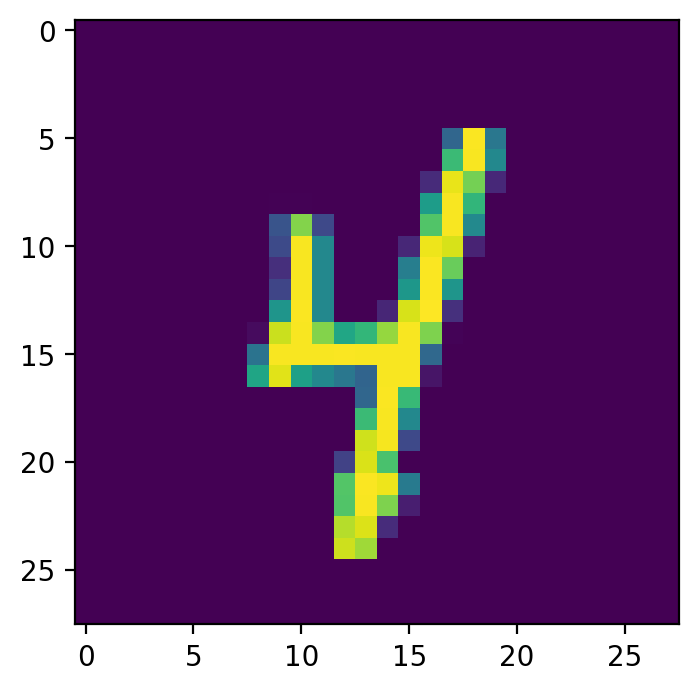

In [22]:
plt.imshow(i)

In [23]:
e[1][0]

<tf.Tensor: shape=(), dtype=int64, numpy=4>

In [27]:
p = model.predict(im)

In [28]:
p.shape

(128, 10)

In [29]:
t = p[0]

In [31]:
np.argmax(t)

4

In [34]:
sm = tf.keras.layers.Softmax()

In [38]:
meins = sm(model.output)

In [42]:
mm = tf.keras.Model(inputs=model.input, outputs=meins)

In [43]:
mm(im)

<tf.Tensor: shape=(128, 10), dtype=float32, numpy=
array([[5.1425718e-06, 1.8319575e-02, 4.3463577e-05, ..., 1.6005764e-04,
        5.1142083e-04, 1.1169482e-03],
       [6.0048421e-07, 9.9865013e-01, 2.4196643e-05, ..., 1.2614659e-03,
        2.1656619e-05, 5.9581607e-06],
       [9.9965322e-01, 5.5898077e-09, 1.2982838e-05, ..., 4.2144457e-09,
        8.1180195e-07, 7.5386487e-07],
       ...,
       [3.3447355e-07, 1.1130666e-04, 4.6524225e-04, ..., 9.9824047e-01,
        8.1167163e-06, 2.6101721e-05],
       [1.3311543e-08, 1.2039908e-08, 1.6086922e-06, ..., 2.3125762e-10,
        1.9370203e-09, 2.4098492e-11],
       [4.9667369e-06, 9.9968541e-01, 1.1704471e-04, ..., 3.2323846e-05,
        1.4163707e-04, 2.5566596e-06]], dtype=float32)>

In [57]:
@interact(i=(0,127))
def mm_plot(i = 0):
    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(im[i])
    ax[1].bar(range(1,11), Out[43][i])
    ax[1].set_xticks(range(1,11))

interactive(children=(IntSlider(value=0, description='i', max=127), Output()), _dom_classes=('widget-interact'…

In [58]:
model.weights

[<tf.Variable 'dense_2/kernel:0' shape=(784, 128) dtype=float32, numpy=
 array([[-0.0784678 , -0.01035945, -0.02908415, ...,  0.07686088,
         -0.00490943, -0.03702372],
        [ 0.06863401,  0.05573548, -0.06102663, ...,  0.04181542,
         -0.06183247, -0.03855152],
        [-0.03764753, -0.03659715,  0.04771172, ..., -0.0458688 ,
          0.04726813,  0.0792697 ],
        ...,
        [-0.00989278, -0.05006088,  0.03803635, ..., -0.02156168,
         -0.07235549,  0.00897661],
        [ 0.06179593, -0.04707681,  0.04510636, ..., -0.01048132,
         -0.05490205, -0.00229399],
        [ 0.01904713, -0.07873177, -0.04064336, ...,  0.06929254,
          0.06509268,  0.03284328]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(128,) dtype=float32, numpy=
 array([ 0.02706814,  0.14346655,  0.08292618, -0.00993588, -0.1123052 ,
        -0.04154807,  0.01522012, -0.00757664, -0.01427385,  0.12775674,
         0.14880957, -0.00577279,  0.00452142, -0.02732761, -0.03835348,


In [61]:
a = tf.ones((2,2))

In [63]:
b = a+a

In [74]:
c = b + tf.eye(2)

In [75]:
c

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[3., 2.],
       [2., 3.]], dtype=float32)>

In [76]:
tf.square(c)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[9., 4.],
       [4., 9.]], dtype=float32)>

784

In [100]:
@interact(w=(4.0, 20.0))
def myplot(w=5.0):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Make data.
    X = np.arange(-w, w, w/400)
    Y = np.arange(-w, w, w/400)
    #X = np.arange(-5, 5, 0.25)
    #Y = np.arange(-5, 5, 0.25)
    X, Y = np.meshgrid(X, Y)
    R = np.sqrt(X**2 + Y**2)
    Z = np.sin(R)

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=10)

interactive(children=(FloatSlider(value=5.0, description='w', max=20.0, min=4.0), Output()), _dom_classes=('wi…

In [16]:
fig.colorbar?

Signature: fig.colorbar(mappable, cax=None, ax=None, use_gridspec=True, **kw)
Docstring:
Add a colorbar to a plot.

Parameters
----------
mappable
    The `matplotlib.cm.ScalarMappable` (i.e., `~matplotlib.image.AxesImage`,
    `~matplotlib.contour.ContourSet`, etc.) described by this colorbar.
    This argument is mandatory for the `.Figure.colorbar` method but optional
    for the `.pyplot.colorbar` function, which sets the default to the current
    image.

    Note that one can create a `.ScalarMappable` "on-the-fly" to generate
    colorbars not attached to a previously drawn artist, e.g. ::

        fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

cax : `~matplotlib.axes.Axes`, optional
    Axes into which the colorbar will be drawn.

ax : `~matplotlib.axes.Axes`, list of Axes, optional
    One or more parent axes from which space for a new colorbar axes will be
    stolen, if *cax* is None.  This has no effect if *cax* is set.

use_gridspec : bool, optional
    If *